Load packages

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

Read dataset

In [18]:
df = pd.read_csv('Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [19]:
print (str(df.shape[0]), str(df.shape[1]))

7043 21


Data Cleaning

In [20]:
#check duplicated value
df.iloc[np.where(df['customerID'].duplicated())]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


In [21]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(subset=['TotalCharges'], inplace=True)
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

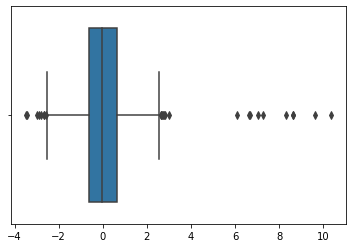

In [22]:
#check outliers
df_outlier=np.concatenate([np.random.normal(0, 1, 1000), np.random.normal(8, 1, 10)])
sns.boxplot(df_outlier)

Feature Preprocessing

In [23]:
y = np.where(df['Churn'] == 'Yes', 1, 0)

In [24]:
#drop irrelevent columns
drop_col = ['customerID', 'Churn']
df_churn = df.drop(drop_col, axis=1)

In [25]:
#transform yes and no to True and False
binary_col = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
df_churn[binary_col] = df_churn[binary_col] == 'Yes'

# transform no to 0, yes to 1 and the third value to 2
binary_col_with_third_option = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                               'TechSupport', 'StreamingTV', 'StreamingMovies']
for col in binary_col_with_third_option:
    df_churn[col] = df_churn[col].apply(lambda x: 0 if x == 'No' else (1 if x == 'Yes' else 2))
    
# Label-encoding
labelencoder = LabelEncoder()
encode_col = ['InternetService', 'Contract', 'PaymentMethod', 'gender']
for col in encode_col:
    df_churn[col] = labelencoder.fit_transform(df_churn[col])

In [26]:
X = df_churn

In [27]:
df['TotalCharges'] = df['TotalCharges'].astype(float)

Model Training

In [28]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

In [29]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [30]:
#models
classifier_KNN = KNeighborsClassifier()
classifier_NB = BernoulliNB()
classifier_DT = DecisionTreeClassifier()
classifier_RF = RandomForestClassifier()
classifier_logistic = LogisticRegression()

In [31]:
names = ['KNN', 'Naive Bayes', 'Decision Trees', 'Random Forest', 'Logistic Regression']
models = [classifier_KNN, classifier_NB, classifier_DT, classifier_RF, classifier_logistic]
count = 0

for classifier in models:
    cv_score = model_selection.cross_val_score(classifier, X_train, y_train, cv=5)
    print(cv_score)
    print('Model accuracy of %s is: %0.4f'%(names[count], cv_score.mean()))
    count += 1

[0.74689165 0.75044405 0.76711111 0.75088968 0.76512456]
Model accuracy of KNN is: 0.7561
[0.73801066 0.75133215 0.768      0.73843416 0.75088968]
Model accuracy of Naive Bayes is: 0.7493
[0.73623446 0.72380107 0.71733333 0.72686833 0.72330961]
Model accuracy of Decision Trees is: 0.7255
[0.78330373 0.78241563 0.78311111 0.77224199 0.77313167]
Model accuracy of Random Forest is: 0.7788
[0.80017762 0.80373002 0.81244444 0.79626335 0.80427046]
Model accuracy of Logistic Regression is: 0.8034


Finding Optimal Hyperparameters

In [32]:
# Grid Search
params = {
    'penalty':('l1', 'l2'), 
    'C':(1, 5, 10, 15, 20)
}

gs = GridSearchCV(LogisticRegression(), params, cv=5)
gs.fit(X_train, y_train)

# Print Best Score
print ("Best score: %0.4f" % gs.best_score_)

# Print Best Parameters
print ("Best parameters set:")
best_params = gs.best_params_
for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_params[param_name]))

best_penalty = best_params['penalty']
best_C = best_params['C']

Best score: 0.8037
Best parameters set:
	C: 10
	penalty: 'l1'


In [34]:
# Feature Selection

In [35]:
X_lr = scaler.fit_transform(X)

LRmodel = LogisticRegression(penalty=best_penalty, C=best_C, solver='liblinear')
LRmodel.fit(X_lr, y)
LRmodel.coef_[0]

keys = df_churn.columns
values = map(lambda x: round(x, 4), LRmodel.coef_[0])
kv_pairs = zip(values, keys)
sorted_kv_pairs = sorted(kv_pairs, key=lambda k_v: (-abs(k_v[0]), k_v[1]))

print ("Logistic Regression (%s) Coefficients" % best_penalty)
for k, v in sorted_kv_pairs:
    print (v + ": " + str(k))

Logistic Regression (l1) Coefficients
tenure: -1.4495
TotalCharges: 0.6951
Contract: -0.5826
InternetService: 0.4523
OnlineSecurity: -0.3732
TechSupport: -0.3593
MonthlyCharges: 0.2385
PaperlessBilling: 0.1796
OnlineBackup: -0.1674
MultipleLines: 0.1434
StreamingMovies: 0.111
PhoneService: -0.1092
StreamingTV: 0.1063
SeniorCitizen: 0.088
DeviceProtection: -0.0801
Dependents: -0.0746
PaymentMethod: 0.0512
gender: -0.0131
Partner: 0.0076
